In [1]:
!pip install rdkit-pypi

In [16]:
# STEP 1: Import libraries
import numpy as np
import pandas as pd
import json
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import classification_report, roc_auc_score, roc_curve, auc
from imblearn.over_sampling import SMOTE
import matplotlib.pyplot as plt
import pickle

In [5]:
# STEP 2: Load SMILES strings and convert to Morgan fingerprints

with open("ligands_can.txt") as f:
    smiles_dict = json.load(f)

smiles_list = list(smiles_dict.values())
print("Loaded", len(smiles_list), "SMILES strings.")

def get_morgan_fp(smiles, radius=2, nBits=256):
    mol = Chem.MolFromSmiles(smiles)
    return list(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits)) if mol else [0]*nBits

drug_features = [get_morgan_fp(sm) for sm in smiles_list]
print("Generated Morgan fingerprints for", len(drug_features), "drugs")


Loaded 68 SMILES strings.
Generated Morgan fingerprints for 68 drugs


In [7]:
# STEP 3: Load protein sequences and compute AA composition
with open("proteins.txt") as f:
    protein_dict = json.load(f)
protein_seqs = list(protein_dict.values())
print("Loaded", len(protein_seqs), "protein sequences.")

def aa_composition(seq):
    aa = 'ACDEFGHIKLMNPQRSTVWY'
    return [seq.count(a)/len(seq) for a in aa]

protein_features = [aa_composition(seq) for seq in protein_seqs]
print("Generated amino acid composition for", len(protein_features), "proteins")


Loaded 442 protein sequences.
Generated amino acid composition for 442 proteins


In [8]:
# STEP 4: Load Y matrix
with open("Y", "rb") as f:
    Y = pickle.load(f, encoding="latin1")
Y = np.array(Y)
print("Y shape:", Y.shape)


Y shape: (68, 442)


In [9]:
# STEP 5: Combine features for all drug-target pairs
X, y = [], []
for i, d_feat in enumerate(drug_features):
    for j, p_feat in enumerate(protein_features):
        X.append(d_feat + p_feat)
        y.append(Y[i][j])
X = np.array(X)
y = np.array(y)
print("Combined feature shape:", X.shape)
print("Label shape:", y.shape)

Combined feature shape: (30056, 276)
Label shape: (30056,)


In [10]:
# STEP 6: Binarize labels for classification
y_binary = np.where(y >= 5.0, 1, 0)


In [11]:
# STEP 7: Split and balance data using SMOTE
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.15, stratify=y_binary, random_state=42)
smote = SMOTE()
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

In [12]:
# STEP 8: Train Random Forest Classifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train_res, y_train_res)

RandomForestClassifier(random_state=42)

In [13]:
# STEP 9: Evaluate model
y_pred = clf.predict(X_test)
y_proba = clf.predict_proba(X_test)[:, 1]
print("Classification Report:")
print(classification_report(y_test, y_pred))
print("ROC-AUC Score:", roc_auc_score(y_test, y_proba))

Classification Report:
              precision    recall  f1-score   support

           0       0.47      0.40      0.43       100
           1       0.99      0.99      0.99      4409

    accuracy                           0.98      4509
   macro avg       0.73      0.69      0.71      4509
weighted avg       0.97      0.98      0.98      4509

ROC-AUC Score: 0.9176786119301428


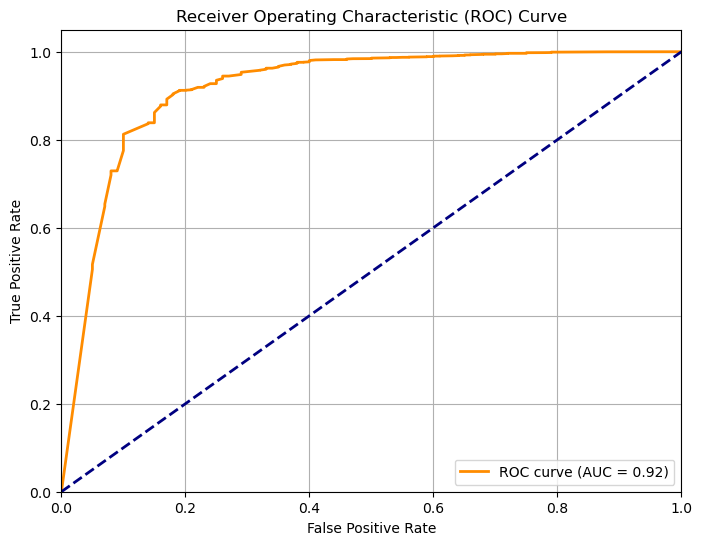

In [14]:
# STEP 10: Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.grid(True)
plt.show()


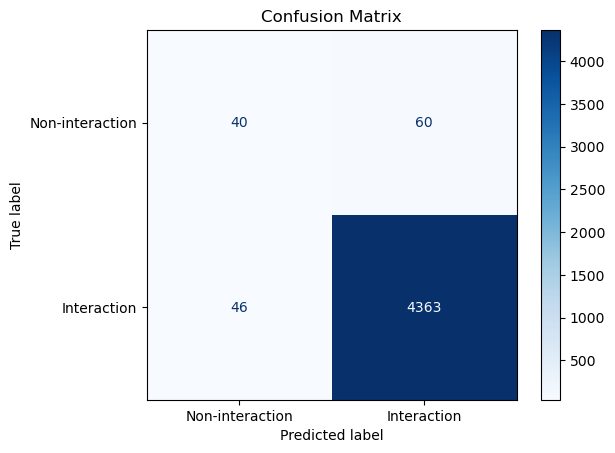

In [17]:

# STEP 11: Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Non-interaction", "Interaction"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.grid(False)
plt.show()
